In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", palette="Set2")
import pandas as pd
import glob
import os
import numpy as np
from simulation_neurog import CellSimulation
import math

layers_gaus_coef = pd.read_csv('layers_gaus_coef.csv')
layers_density = pd.read_csv('layers_percent.csv')

# sim colors
neuro_colors = ['#1c9d40', '#c21745', '#23a3ae', '#e46b0f', '#666666']
neuro_labels = ['apical P', 'basal P', 'apical N', 'basal N']
neuro_colors_dict = dict(zip(neuro_labels, neuro_colors))

# layer colors
layer_colors = {'l6': '#ae0000',
                'l5': '#e33e00',
                'l4': '#ffc000',
                'l23': '#0088ab'}
layers = layer_colors.keys()
colors = [layer_colors.get(layer, '#333333') for layer in layers]

# Raw

calculation: 100%|██████████| 192/192 [00:24<00:00,  7.92it/s]


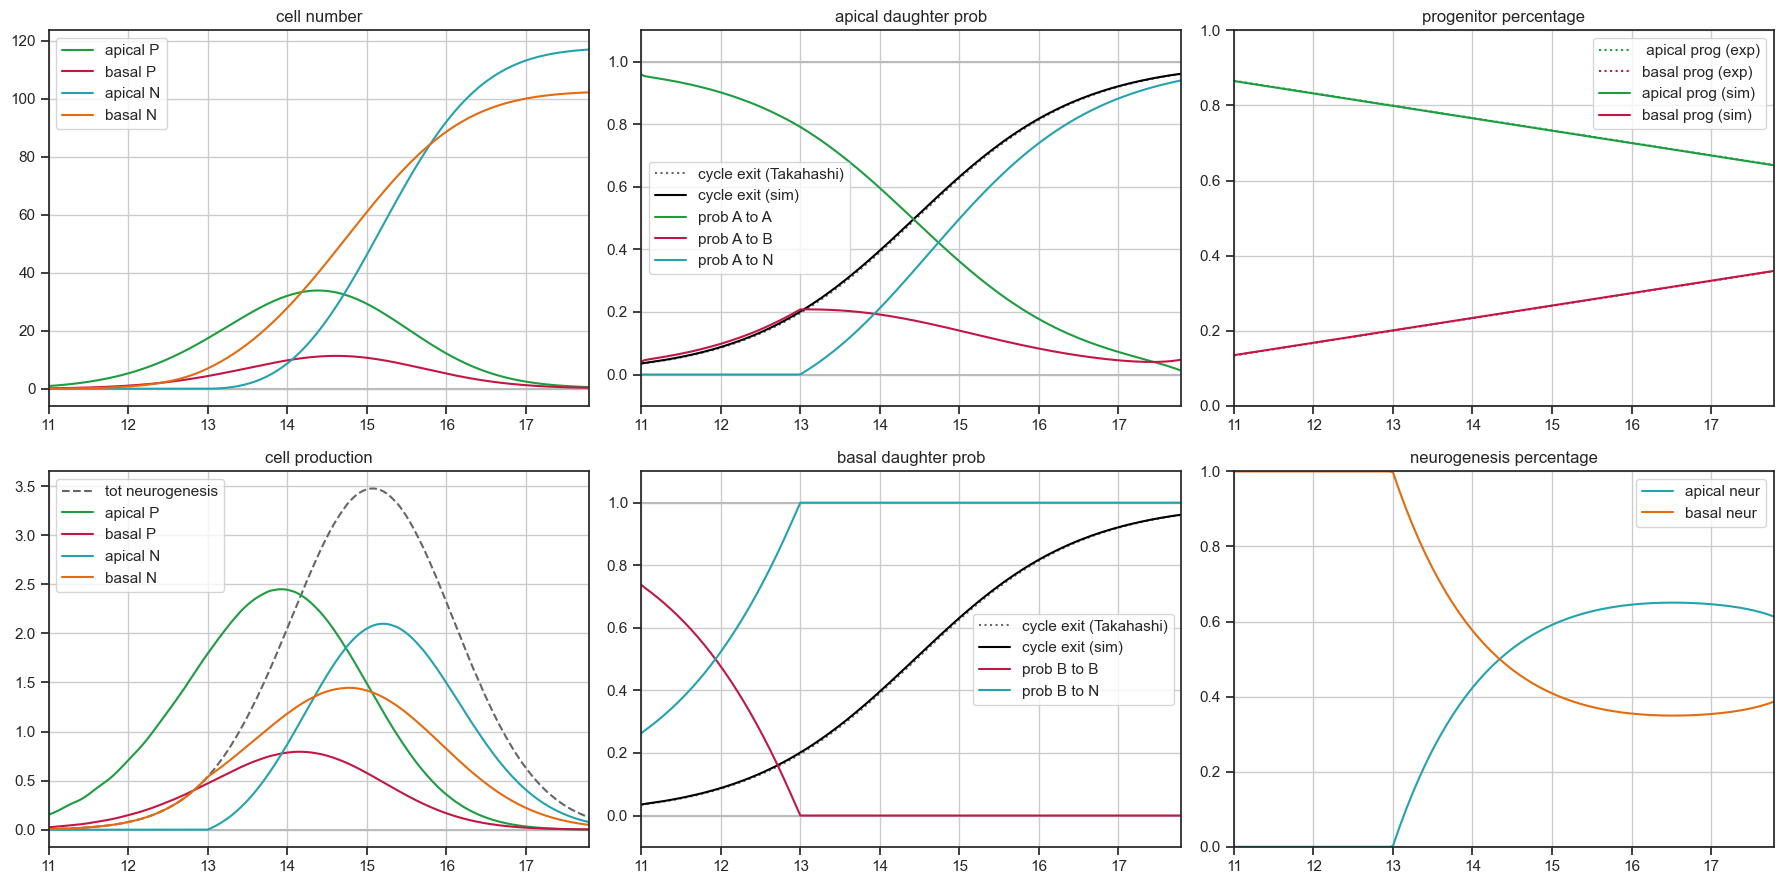

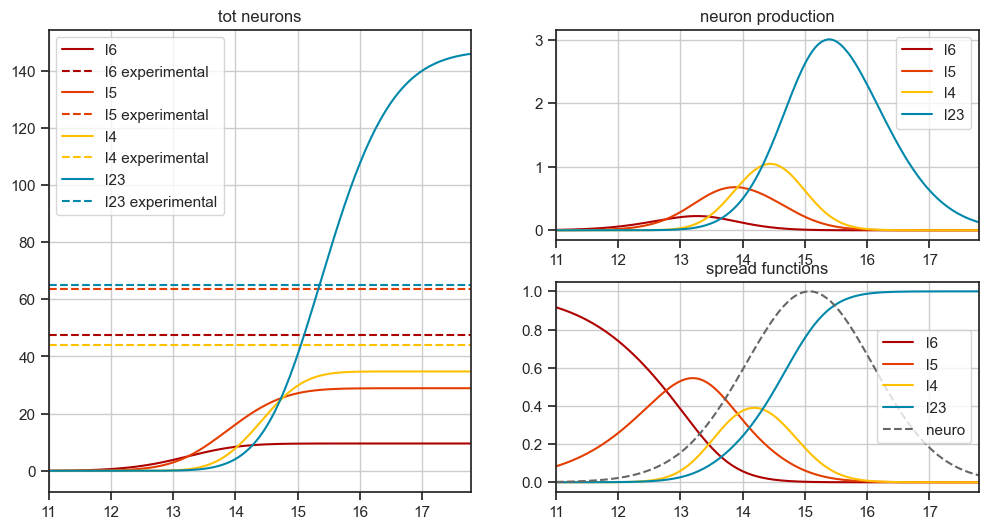

In [46]:
k = 0.866

sim_raw = CellSimulation(
            n_aP0=k, n_bP0=1-k,

            layers_dist=layers_gaus_coef,
            layers_perc=layers_density,
            clip_prob=True)

sim_raw.run()

sim_raw.plot()

sim_raw.plot_layers()

# D-I

calculation: 100%|██████████| 192/192 [00:13<00:00, 14.14it/s]


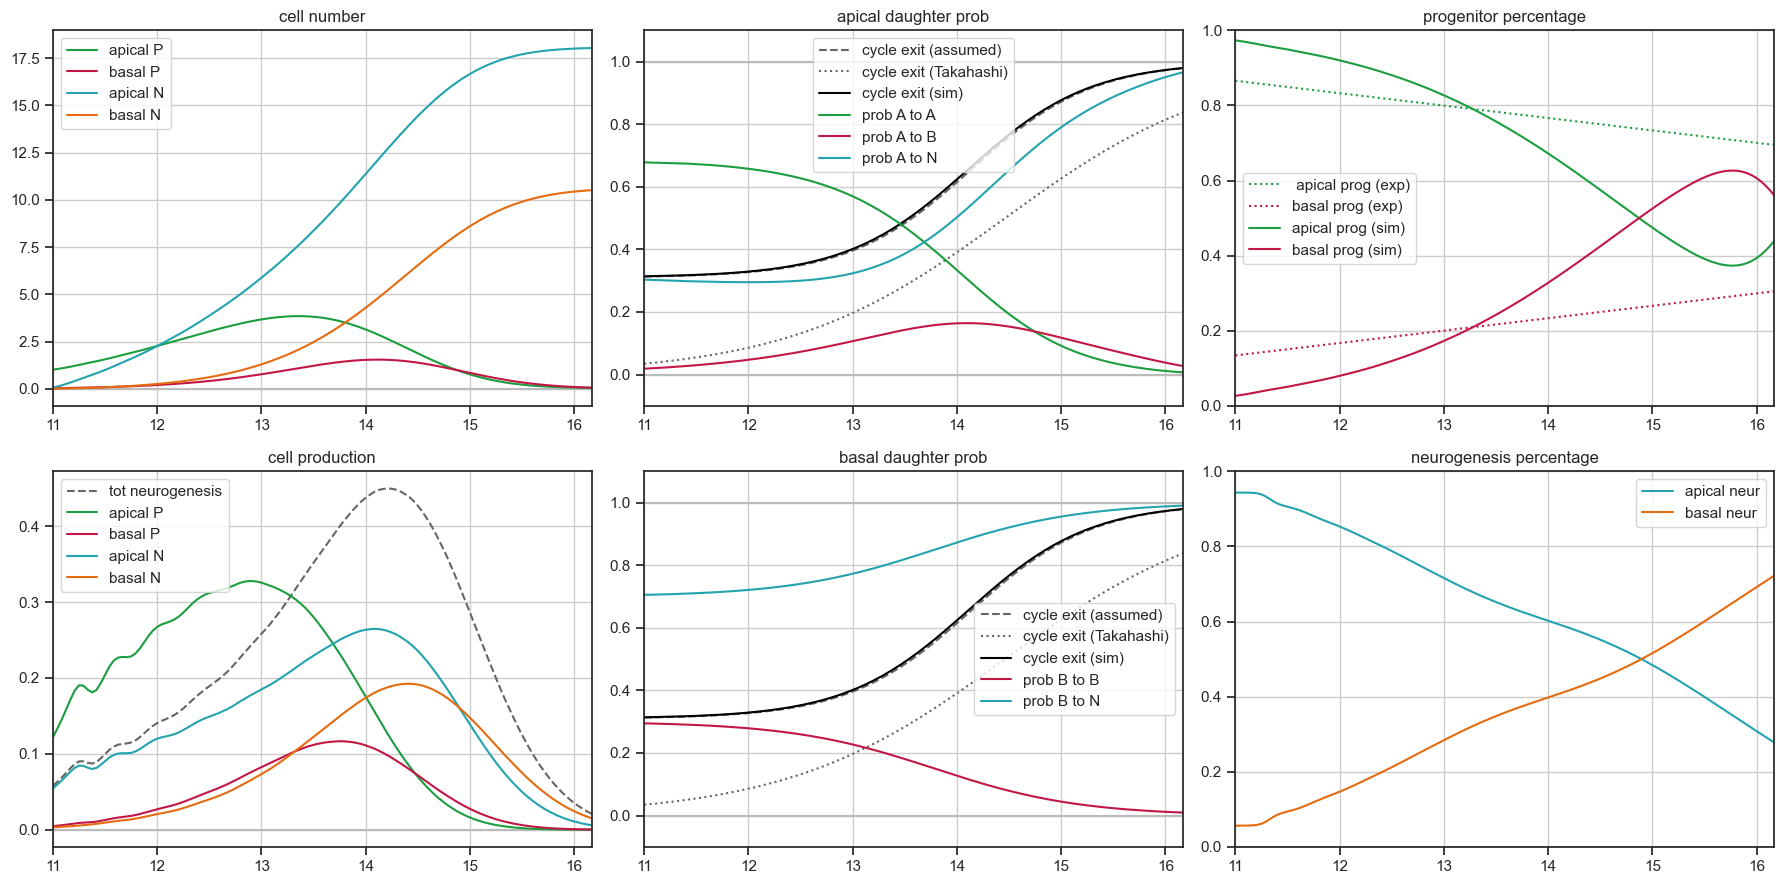

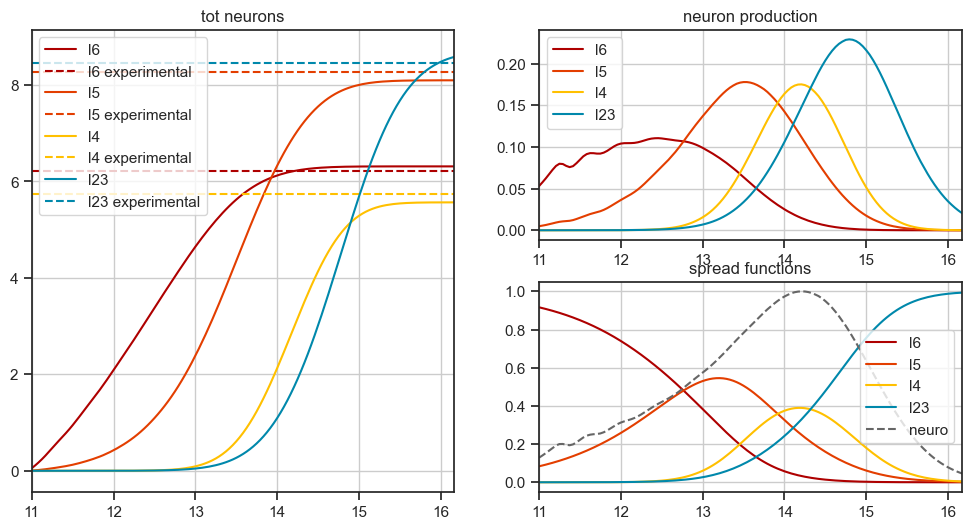

In [47]:
a0_perc = 0.975

# sigmoid cell cycle exit
x0_pE = 3.136
k_pE = 1.714
start_pE= 0.31
test_pE_fc = lambda x: 1/(1 + np.exp(-k_pE*(x - x0_pE)))*(1-start_pE) + start_pE

# sigmoid basal production from apical
test_pA_to_B_fc = lambda x: 1/(1 + np.exp(-0.962*(x-3.762)))

# sigmoid neuron production from basal
start_pB_to_N_fc = 0.7
test_pB_to_N_fc = lambda x: 1/(1 + np.exp(-1.443*(x-2.808)))*(1-start_pB_to_N_fc) + start_pB_to_N_fc


sim_D_I = CellSimulation(
            n_aP0=a0_perc, n_bP0=1-a0_perc,

            layers_dist=layers_gaus_coef,
            layers_perc=layers_density,

            # cell cycle exit just from aP and faster curve to get earlier neurogenesis peak
            pE_fc = test_pE_fc,

            pA_to_B_fc = test_pA_to_B_fc,

            pB_to_N_fc = test_pB_to_N_fc
            )

sim_D_I.run()

sim_D_I.plot()

sim_D_I.plot_layers()

# I-D

calculation: 100%|██████████| 192/192 [00:21<00:00,  8.74it/s]


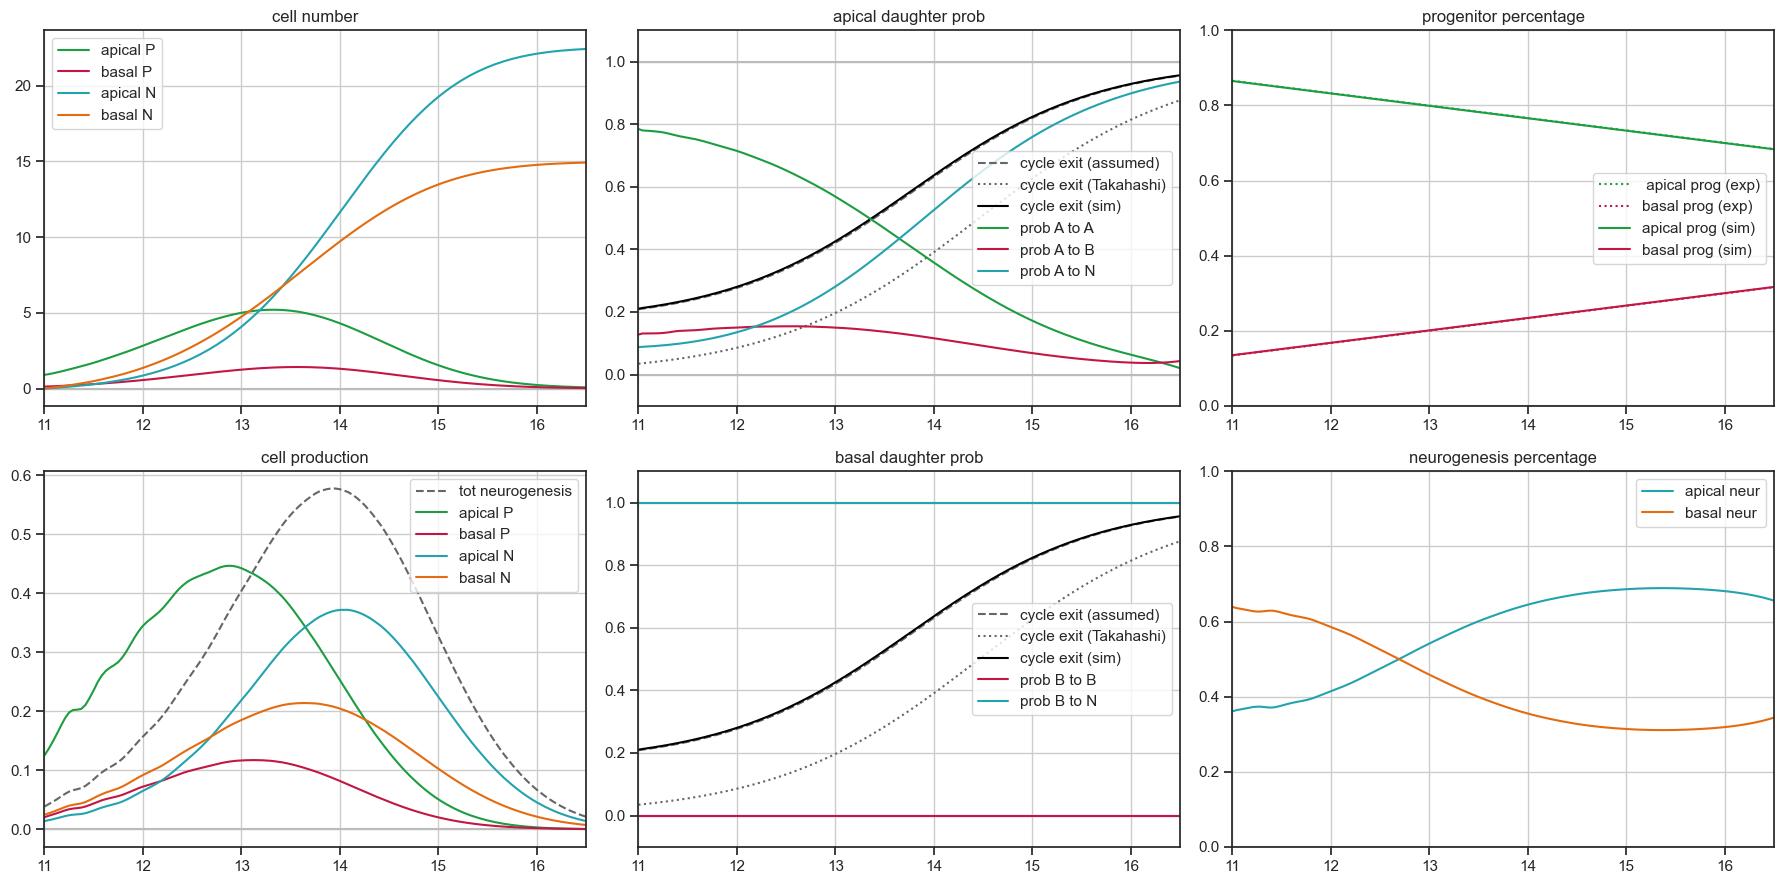

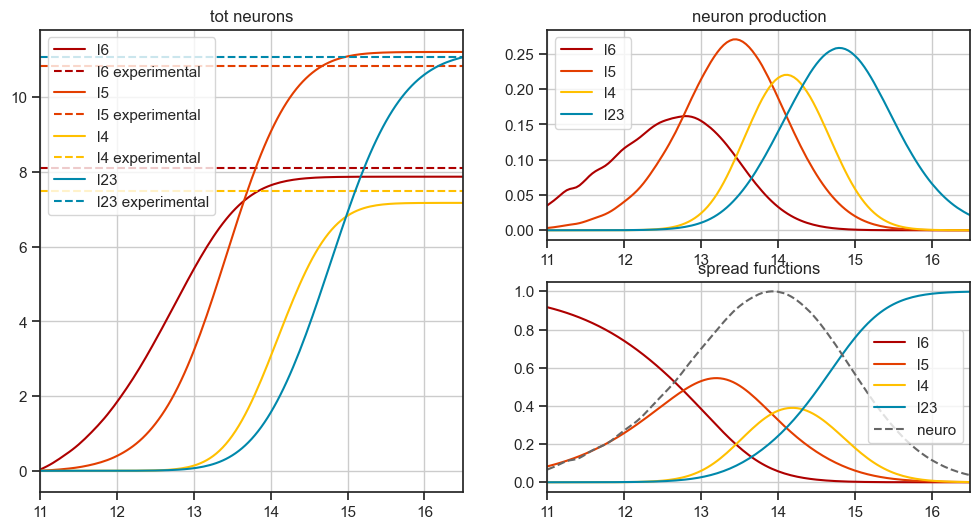

In [48]:
# cell cycle exit sigmoid parameters
x0 = 2.78
k = 1.058
start = 0.167

# starting percentage of apical progenitors
a0_perc = 0.866

sim_I_D = CellSimulation(
            n_aP0=a0_perc, n_bP0=1-a0_perc,
            pE_fc = lambda x: 1/(1 + np.exp(-k*(x-x0)))*(1-start) + start,

            layers_dist=layers_gaus_coef,
            layers_perc=layers_density)

sim_I_D.run()

sim_I_D.plot()

sim_I_D.plot_layers()

# plots

In [49]:
sim_names = ['Raw', 'D_I', 'I_D']

sims = [sim_raw, sim_D_I, sim_I_D]

metrics_dicts = []
tables_dict = {}

for i, sim in enumerate(sims):
    metrics_dict = sim.get_metrics()
    metrics_dict['source'] = sim_names[i]
    metrics_dicts.append(metrics_dict)
    
    tables_dict[sim_names[i]] = sim.get_tables()

metrics_df = pd.DataFrame(metrics_dicts)

### start and end of neurogenesis

In [50]:
metrics_source = metrics_df['source'].values

# let's get the end point (neurons > 99.5%)
end_points_values = metrics_df['end_point'].values

end_points_dict = dict(zip(metrics_source, end_points_values))

# let's get the end point (neurons < 0.5%)
start_points_values = metrics_df['start_point'].values

start_points_dict = dict(zip(metrics_source, start_points_values))

### days vector

In [51]:
days_vc = tables_dict['Raw']['days']

## percentage progenitors

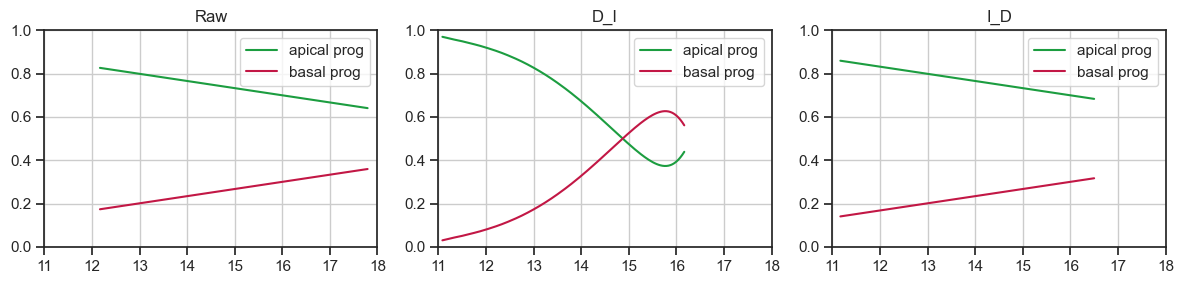

In [52]:
k = len(sims)

cols = 3

fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 3))

axes = axes.flatten()

for i, s in enumerate(sim_names):
    ax = axes[i]

    x = days_vc

    prog_n = tables_dict[s]['n_cells'][:2]

    # perc_a
    y = prog_n[0] / np.sum(prog_n, axis = 0)


    current_start = start_points_dict[s]
    current_end = end_points_dict[s]

    y[x<current_start] = None
    y[x>current_end] = None

    ax.plot(x, y, color = neuro_colors_dict['apical P'], label = 'apical prog')
    ax.plot(x, 1-y, color = neuro_colors_dict['basal P'], label = 'basal prog')
    ax.set_title(f'{s}')

    ax.set_xlim([11,18])
    ax.set_ylim([0,1])

    ax.legend()
    ax.grid()

# hide any unused subplots if k < rows*cols
for j in range(k, cols):
    fig.delaxes(axes[j])

plt.tight_layout()

fig.savefig(f'results/progenitor percentage.pdf', dpi=300)
plt.show()

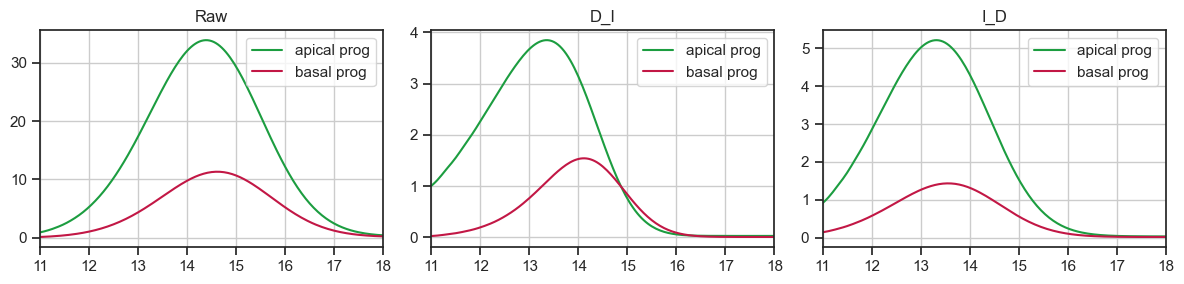

In [53]:
k = len(sims)

cols = 3

fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 3))

axes = axes.flatten()

for i, s in enumerate(sim_names):
    ax = axes[i]

    x = days_vc

    prog_n = tables_dict[s]['n_cells'][:2]

    # perc_a
    y_a = prog_n[0]
    y_b = prog_n[1]


    current_start = start_points_dict[s]
    current_end = end_points_dict[s]

    y[x<current_start] = None
    y[x>current_end] = None

    ax.plot(x, y_a, color = neuro_colors_dict['apical P'], label = 'apical prog')
    ax.plot(x, y_b, color = neuro_colors_dict['basal P'], label = 'basal prog')
    ax.set_title(f'{s}')

    ax.set_xlim([11,18])

    ax.legend()
    ax.grid()

# hide any unused subplots if k < rows*cols
for j in range(k, cols):
    fig.delaxes(axes[j])

plt.tight_layout()

fig.savefig(f'results/progenitor number.pdf', dpi=300)
plt.show()

## direct - indirect neurogenesis

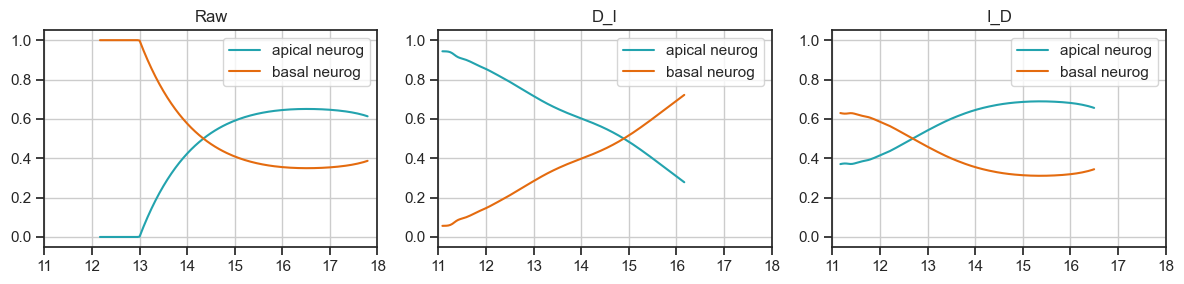

In [54]:
k = len(sims)

cols = 3

fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 3))

axes = axes.flatten()

for i, s in enumerate(sim_names):
    ax = axes[i]

    x = days_vc

    neurogenesis_n = tables_dict[s]['new_cells'][2:]

    # perc_a
    y = neurogenesis_n[0] / np.sum(neurogenesis_n, axis = 0)


    current_start = start_points_dict[s]
    current_end = end_points_dict[s]

    y[x<current_start] = None
    y[x>current_end] = None

    ax.plot(x, y, color = neuro_colors_dict['apical N'], label = 'apical neurog')
    ax.plot(x, 1-y, color = neuro_colors_dict['basal N'], label = 'basal neurog')
    ax.set_title(f'{s}')

    ax.set_xlim([11,18])
    ax.set_ylim([-0.05,1.05])

    ax.legend()
    ax.grid()

# hide any unused subplots if k < rows*cols
for j in range(k, cols):
    fig.delaxes(axes[j])

plt.tight_layout()

fig.savefig(f'results/neurogenesis percentage.pdf', dpi=300)
plt.show()

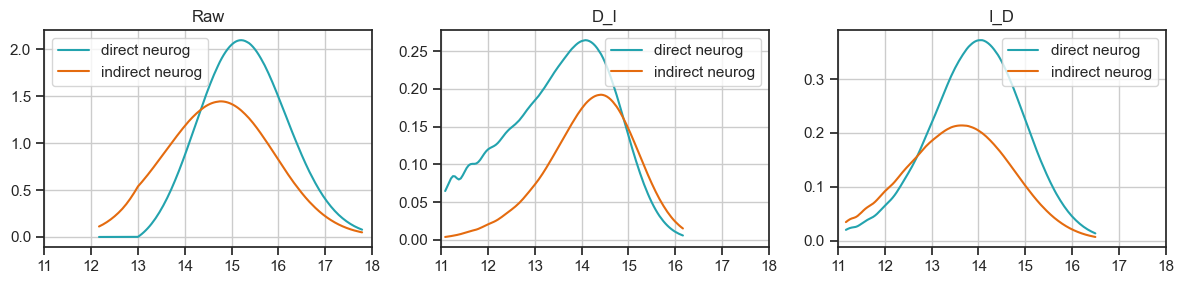

In [55]:
k = len(sims)

cols = 3

fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 3))

axes = axes.flatten()

for i, s in enumerate(sim_names):
    ax = axes[i]

    x = days_vc

    neurogenesis_n = tables_dict[s]['new_cells'][2:]

    # perc_a
    y_a = neurogenesis_n[0]
    y_b = neurogenesis_n[1]


    current_start = start_points_dict[s]
    current_end = end_points_dict[s]

    y_a[x<current_start] = None
    y_a[x>current_end] = None

    y_b[x<current_start] = None
    y_b[x>current_end] = None

    ax.plot(x, y_a, color = neuro_colors_dict['apical N'], label = 'direct neurog')
    ax.plot(x, y_b, color = neuro_colors_dict['basal N'], label = 'indirect neurog')
    ax.set_title(f'{s}')

    ax.set_xlim([11,18])

    ax.legend()
    ax.grid()

# hide any unused subplots if k < rows*cols
for j in range(k, cols):
    fig.delaxes(axes[j])

plt.tight_layout()

fig.savefig(f'results/neurogenesis number.pdf', dpi=300)
plt.show()

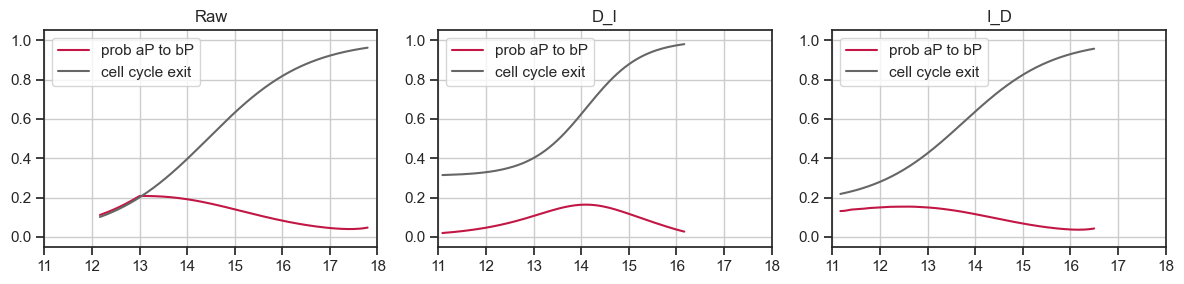

In [56]:
k = len(sims)

cols = 3

fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 3))

axes = axes.flatten()

for i, s in enumerate(sim_names):
    ax = axes[i]

    x = days_vc

    y_pE = tables_dict[s]['probs'][5]
    y_pA_to_B = tables_dict[s]['probs'][1]


    current_start = start_points_dict[s]
    current_end = end_points_dict[s]

    y_pE[x<current_start] = None
    y_pE[x>current_end] = None

    y_pA_to_B[x<current_start] = None
    y_pA_to_B[x>current_end] = None

    ax.plot(x, y_pA_to_B, color = neuro_colors_dict['basal P'], label = 'prob aP to bP')
    ax.plot(x, y_pE, color = neuro_colors[4], label = 'cell cycle exit')
    ax.set_title(f'{s}')

    ax.set_xlim([11,18])
    ax.set_ylim([-0.05,1.05])

    ax.legend()
    ax.grid()

# hide any unused subplots if k < rows*cols
for j in range(k, cols):
    fig.delaxes(axes[j])

plt.tight_layout()

fig.savefig(f'results/cycle exit and pA_to_B.pdf', dpi=300)
plt.show()

## layers

In [57]:
layers_n_df = pd.DataFrame()

layers_n_df = metrics_df[[col for col in metrics_df.columns if col.endswith('_n')]]
layers_n_df.columns = layers_n_df.columns.str.slice(stop=-2)

layers_n_df = layers_n_df.set_index(metrics_df['source'])

layers_n_df

,l6,l5,l4,l23
source,,,,
Raw,9.555785,28.897398,34.765555,146.946759
D_I,6.311890,8.096867,5.566399,8.708176
I_D,7.874192,11.213998,7.173196,11.244476


In [58]:
layers_p_df = pd.DataFrame()

layers_p_df = metrics_df[[col for col in metrics_df.columns if col.endswith('_p')]]
layers_p_df.columns = layers_p_df.columns.str.slice(stop=-2)

layers_p_df = layers_p_df.set_index(metrics_df['source'])

layers_p_df

,l6,l5,l4,l23
source,,,,
Raw,0.043403,0.131253,0.157906,0.667438
D_I,0.220054,0.282285,0.194064,0.303597
I_D,0.209946,0.298993,0.191255,0.299806


### layer absolute numbers

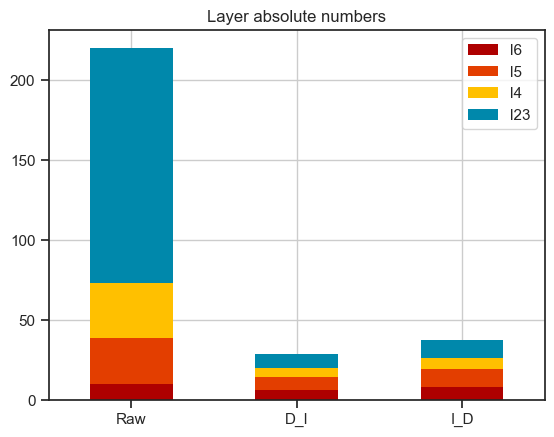

In [63]:
fig, ax = plt.subplots()

layers_n_df.plot(kind='bar', stacked=True, color = colors, edgecolor='none', linewidth=0, ax=ax)
ax.set_xticklabels(layers_n_df.index, rotation = 0)
ax.grid()
ax.set_axisbelow(True)
ax.set_xlabel('')
ax.set_title('Layer absolute numbers')


fig.savefig(f'results/layer number.pdf', dpi=300)

### layer percentages

In [60]:
layers_density = pd.read_csv('layers_percent.csv')
# i want to sum starting from l6
layers_perc = layers_density['percent'].values[::-1]

print(layers_density)
print()
print(layers_perc)

layers_perc = np.cumsum(layers_perc)
print(layers_perc)

  layer   percent
0   l23  0.295036
1    l4  0.199940
2    l5  0.288617
3    l6  0.216406

[0.21640608 0.28861736 0.19994028 0.29503627]
[0.21640608 0.50502345 0.70496373 1.        ]


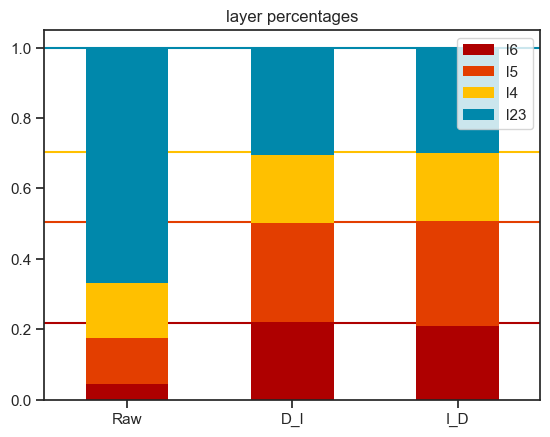

In [61]:
fig, ax = plt.subplots()

layers_p_df.plot(kind='bar', stacked=True, color=colors, ax=ax, edgecolor='none', linewidth=0)
ax.set_xticklabels(layers_p_df.index, rotation = 0)

for i in range(4):
    current_layer =  layers_perc[i]
    ax.hlines(y = current_layer, xmin = -5, xmax = len(layers_p_df), color=colors[i], zorder=0)

ax.set_xlabel('')
ax.set_title('layer percentages')
fig.savefig('results/layer percentage.pdf', dpi=300)

### direct_indirect layers contribution

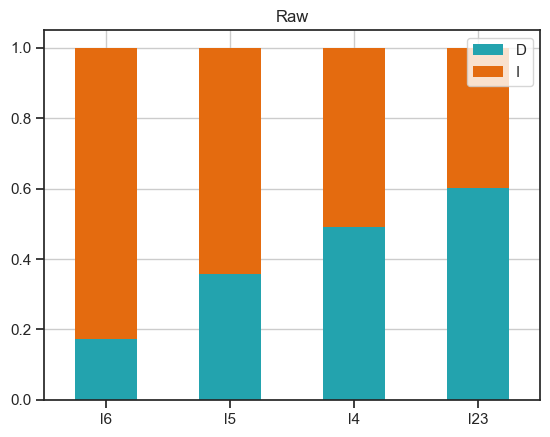

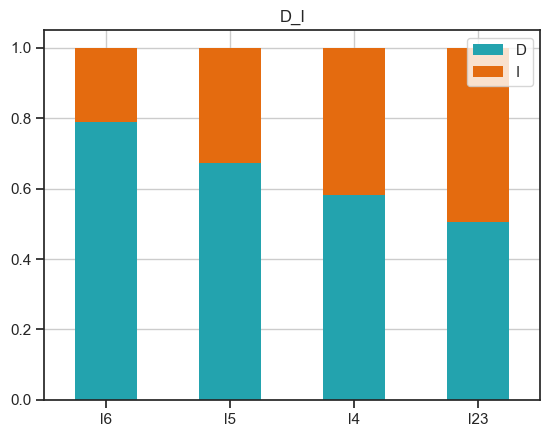

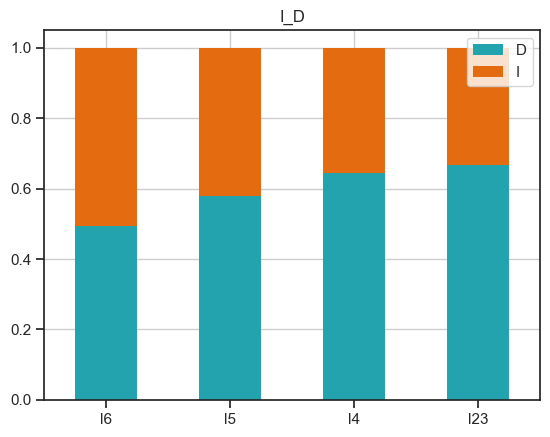

In [62]:
layer_names = list(layer_colors.keys())

for sim_name in sim_names:

    layers_np = tables_dict[sim_name]['layers']

    layers_aggregate = np.sum(layers_np, axis = 2)

    perc_dict = {}

    for i in range(layers_aggregate.shape[1]):
        l = layers_aggregate[:,i]
        
        perc_dict[layer_names[i]] = float(l[0] / np.sum(l))

    perc_df = pd.DataFrame.from_dict(perc_dict, orient='index', columns=['D'])
    perc_df['I'] = 1 - perc_df['D']


    # print(perc_df)
    fig, ax = plt.subplots()

    ax = perc_df.plot(kind='bar', stacked=True, color = neuro_colors[2:4], edgecolor='none', linewidth=0, ax=ax)
    ax.set_xticklabels(perc_df.index, rotation = 0)
    ax.grid()
    ax.set_axisbelow(True)
    ax.set_xlabel('')
    ax.set_title(sim_name)
    fig.savefig(f'results/layers D-I {sim_name}.pdf', dpi=300)
